# Fairness Linear Learner  in SageMaker

1. [Introduction](#Introduction)
    1. [Fairness definition](#fairness)
2. [Prerequisites and Data](#pre_and_data)
    1. [Initialize SageMaker](#initsagemaker)
    2. [Loading the data: Adult Dataset](#load_data) 
    3. [Data inspection](#inspect_data) 
    4. [Data encoding](#encode_data) 
    5. [Data conversion and upload of the training data](#upload_data) 
3. [Training the standard linear model](#train_linear_model)
    1. [Accuracy and Fairness of the model](#performance_linear_model)
4. [Changing the data to impose fairness](#impose_fairness)
    1. [Train the model with the fair data](#train_fair_model)
    2. [Accuracy and Fairness of the fair model](#performance_fair_model)
    3. [Sanity check: performance on the training set](#performance_fair_model_train)
5. [Distribution of the outputs](#distrib)
    


## Introduction <a class="anchor" id="Introduction">
The idea of possible racist Machine Learning algorithms that mimics the human prejudice is from less than a decade ago. Nowadays, several Machine Learning methods have strong social implications, for example they are used to predict bank loans, insurance rates or advertising. Unfortunately, an algorithm that learns from historical data will naturally inherit the past biases. In this notebook, we present how to overcome this problem by using SageMaker and Fair Algorithms in the context of Linear Learners.

### Fairness definition <a class="anchor" id="fairness">
We introduce here a classic measure of Fariness. Giving a dataset, we can consider a binary sensitive feature (for example, gender between male and female). We show here definition of Equal Opportunity among these two groups $A$ (female) and $B$ (male) and a trained model $f$:

$$\exists V \geq 0 :\mathbb{P}_{(x,y)} \big[ f(x)>0 \, \big| \, x \text{ in group } g, y = 1 \big] = V, \,\,\,\, g={A,B}.$$

Starting from this definition, we can estimate the Difference in Equal Opportunity (DEO) as:

$$DEO(f) = \Big| \mathbb{P}_{(x,y)}\big[ f(x)>0 \, \big| \, x \text{ in group } A, y = 1 \big] -  \mathbb{P}_{(x,y)} \big[ f(x)>0 \, \big| \, x \text{ in group } B, y = 1 \big] \Big|.$$

A low value of this measure means a fair model $f$ with respect to the sensitive feature.

Now, we introduce two methods to evalute empirically measure from the model or directly from a list of predictions.

In [1]:
from sklearn.metrics import confusion_matrix

def deo_from_model(model, dataset, sensitive_feature, groupA_value=None):
    if groupA_value == None:
        groupA_value = np.max(dataset[:, sensitive_feature])
        
    groupA_idxs = [idx for idx, val in enumerate(dataset)
                   if val[sensitive_feature] == groupA_value]
    groupB_idxs = [idx for idx, val in enumerate(dataset)
                   if val[sensitive_feature] != groupA_value]
    
    print('Examples in group A: %d' % len(groupA_idxs))
    print('Examples in group B: %d' % len(groupB_idxs))
    
    pred = []
    for array in np.array_split(dataset[:,:-1], 100):
        result = model.predict(array)
        pred += [r['predicted_label'] for r in result['predictions']]
    
    pred = np.array(pred)
    
    tnA, fpA, fnA, tpA  = confusion_matrix(np.where(dataset[groupA_idxs][:,-1] == 1, 1, 0),
                           pred[groupA_idxs]).ravel()
    tnB, fpB, fnB, tpB  = confusion_matrix(np.where(dataset[groupB_idxs][:,-1] == 1, 1, 0),
                                           pred[groupB_idxs]).ravel()
    
    

    print('TPR group A: %f' % (float(tpA) / (tpA + fnA)))
    print('TPR group B: %f' % (float(tpB) / (tpB + fnB)))
    print('TPR all dataset: %f' % (float(tpA + tpB) / (tpA + fnA + tpB + fnB)))
    print('Accuracy all dataset: %f' % (float(tpA + tnA + tpB + tnB) /
          (tpA + fpA + fnA + tnA + tpB + fpB + fnB + tnB)))
    
    return(np.abs(float(tpA) / (tpA + fnA) - float(tpB) / (tpB + fnB)))

def deo_from_list(datset, predictions, groupA_idxs, groupB_idxs):
    tnA, fpA, fnA, tpA  = confusion_matrix(np.where(datset[groupA_idxs][:,-1] == 1, 1, 0),
                           predictions[groupA_idxs]).ravel()
    tnB, fpB, fnB, tpB  = confusion_matrix(np.where(datset[groupB_idxs][:,-1] == 1, 1, 0),
                                           predictions[groupB_idxs]).ravel()

    print('Examples in group A: %d' % len(groupA_idxs))
    print('Examples in group B: %d' % len(groupB_idxs))

    print('TPR group A: %f' % (float(tpA) / (tpA + fnA)))
    print('TPR group B: %f' % (float(tpB) / (tpB + fnB)))
    print('TPR all dataset: %f' % (float(tpA + tpB) / (tpA + fnA + tpB + fnB)))
    print('Accuracy all dataset: %f' % (float(tpA + tnA + tpB + tnB) /
          (tpA + fpA + fnA + tnA + tpB + fpB + fnB + tnB)))
    
    return(np.abs(float(tpA) / (tpA + fnA) - float(tpB) / (tpB + fnB)))

## Prequisites and Data <a class="anchor" id="pre_and_data">
### Initialize SageMaker  <a class="anchor" id="initsagemaker">

In [2]:
bucket = 'fairness-test2'
prefix = 'sagemaker/DEMO-linear-adult'

# Define IAM role
from sagemaker import get_execution_role
import pandas as pd
import numpy as np
import sklearn.preprocessing as preprocessing
import seaborn as sns

role = get_execution_role()

### Loading the data: Adult Dataset <a class="anchor" id="load_data">
From UCI repository, this database contains 14 features concerning demographic characteristics of $45222$ instances ($32561$ for training and $12661$ for test). The task is to predict if a person has an income per year that is more (or less) than $50000\,\$$.

Here the list of the features and their possible values:
- (1) **Age**: continuous.
- (2) **Workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- (3) **Fnlwgt**: continuous (the number of people the census takers believe that observation represents).
- (4) **Education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
- (5) **Education-num**: continuous.
- (6) **Marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
- (7) **Occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- (8) **Relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
- (9) **Ethnic group**: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
- (10) **Gender**: Female, Male.
- (11) **Capital-gain**: continuous.
- (12) **Capital-loss**: continuous.
- (13) **Hours-per-week**: continuous.
- (14) **Native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

And finally our binary prediction task:
- (15) **Target**: <=50, >50.

In [3]:
%%time
original_data = pd.read_csv(
    "adult.data",
    names=[
        "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Ethnic group", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"],
        sep=r'\s*,\s*',
        engine='python',
        na_values="?")
original_test = pd.read_csv(
    "adult.test",
    names=[
        "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Ethnic group", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"],
        sep=r'\s*,\s*',
        engine='python',
        na_values="?")

CPU times: user 1 s, sys: 36 ms, total: 1.04 s
Wall time: 1.04 s


### Data inspection  <a class="anchor" id="inspect_data">
Plotting histograms of the distribution of the different features is a good way to visualize the data. We plot both the whole dataset distributions (left) and the distrubtions in the case of positive labels only (right).

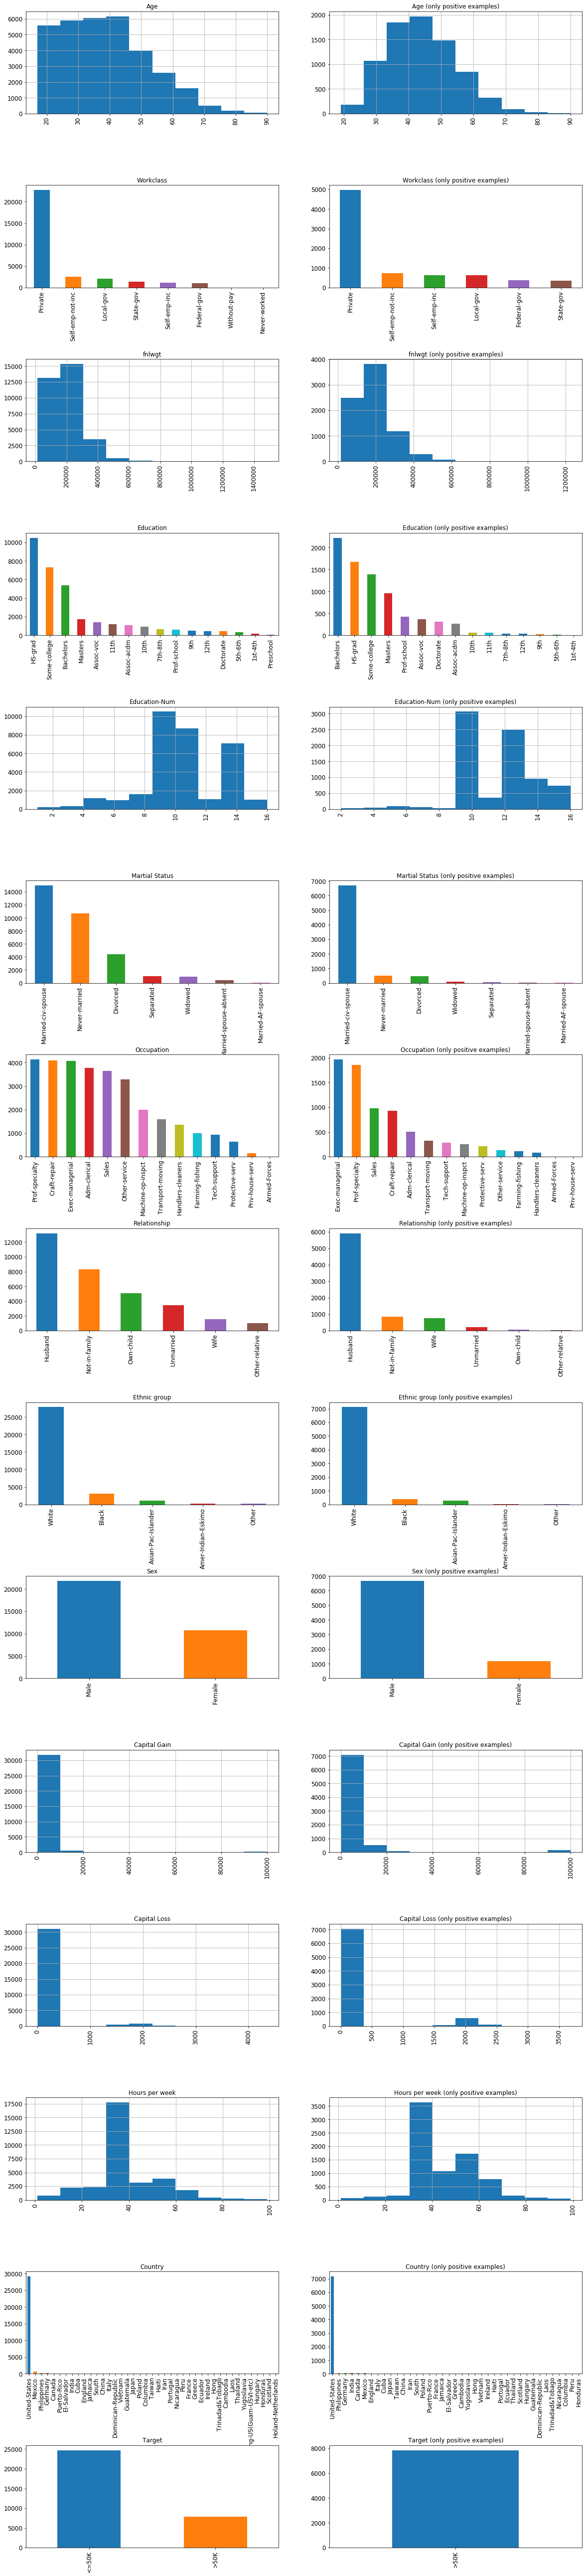

In [24]:
import matplotlib.pyplot as plt
from math import ceil

positive_idxs = [idx for idx, val in enumerate(original_data['Target']) if val == ">50K"]

fig = plt.figure(figsize=(20,100))
cols = 2
rows = ceil(float(original_data.shape[1]) / cols) * 2
for i, column in enumerate(original_data.columns):
    ax = fig.add_subplot(rows, cols, 2 * i + 1)
    ax.set_title(column)
    if original_data.dtypes[column] == np.object:
        original_data[column][:].value_counts(sort=True).plot(kind="bar", axes=ax)
    else:
        original_data[column][:].hist(axes=ax)
        plt.xticks(rotation="vertical")
        
    ax = fig.add_subplot(rows, cols, 2 * i + 2)
    ax.set_title(column + " (only positive examples)")
    if original_data.dtypes[column] == np.object:
        original_data[column][positive_idxs].value_counts(sort=True).plot(kind="bar", axes=ax)
    else:
        original_data[column][positive_idxs].hist(axes=ax)
        plt.xticks(rotation="vertical")

plt.subplots_adjust(hspace=0.7, wspace=0.2)

### Data encoding   <a class="anchor" id="encode_data">
We apply a preprocessing encoder for the categorial features.

In [5]:
# Encode the categorical features as numbers
def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            #  print('Column:', column, result[column])
            result[column] = encoders[column].fit_transform(result[column].fillna('None'))
    return result, encoders

# Calculate the correlation and plot it
encoded_data, _ = number_encode_features(original_data)
training_data_matrix = np.array(encoded_data.values, dtype=float)
encoded_data, _ = number_encode_features(original_test)
test_data_matrix = np.array(encoded_data.fillna(0).values, dtype=float)

scaler = preprocessing.MinMaxScaler(feature_range=(0.0, 1.0))
training_data_matrix = scaler.fit_transform(training_data_matrix)
test_data_matrix = scaler.transform(test_data_matrix)

### Data conversion and upload of the training data    <a class="anchor" id="upload_data">

Since algorithms have particular input and output requirements, converting the dataset is also part of the process that a data scientist goes through prior to initiating training. In this particular case, the Amazon SageMaker implementation of Linear Learner takes recordIO-wrapped protobuf, where the data we have today is a pickle-ized numpy array on disk.

We also need to upload it to S3, so that Amazon SageMaker training can use it.

In [6]:
import io
import numpy as np
import sagemaker.amazon.common as smac
import boto3
import os

vectors = np.array([t.tolist() for t in training_data_matrix[:,:-1]]).astype('float32')
labels = np.where(np.array([t.tolist() for t in training_data_matrix[:,-1]]) == 1, 1, 0).astype('float32')

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, vectors, labels)
buf.seek(0)

key = 'recordio-pb-data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

uploaded training data location: s3://fairness-test2/sagemaker/DEMO-linear-adult/train/recordio-pb-data


Let's also setup an output S3 location for the model artifact that will be output as the result of training with the algorithm.

In [7]:
output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('training artifacts will be uploaded to: {}'.format(output_location))

training artifacts will be uploaded to: s3://fairness-test2/sagemaker/DEMO-linear-adult/output


## Standard linear model  <a class="anchor" id="train_linear_model">

Once we have the data preprocessed and available in the correct format for training, the next step is to actually train the model using the data. First, let's specify our containers.  Since we want this notebook to run in all 4 of Amazon SageMaker's regions, we'll create a small lookup.  More details on algorithm containers can be found in [AWS documentation](https://docs-aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html).

In [8]:
containers = {'us-west-2': '174872318107.dkr.ecr.us-west-2.amazonaws.com/linear-learner:latest',
              'us-east-1': '382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:latest',
              'us-east-2': '404615174143.dkr.ecr.us-east-2.amazonaws.com/linear-learner:latest',
              'eu-west-1': '438346466558.dkr.ecr.eu-west-1.amazonaws.com/linear-learner:latest'}

import sagemaker

sess = sagemaker.Session()

linear = sagemaker.estimator.Estimator(containers[boto3.Session().region_name],
                                       role, 
                                       train_instance_count=1, 
                                       train_instance_type='ml.c4.xlarge',
                                       output_path=output_location,
                                       sagemaker_session=sess)
linear.set_hyperparameters(feature_dim=14,
                           predictor_type='binary_classifier',
                           mini_batch_size=200)
                           #loss='hinge_loss')

linear.fit({'train': s3_train_data})

INFO:sagemaker:Creating training-job with name: linear-learner-2018-06-20-20-53-54-262


..................
Docker entrypoint called with argument(s): train
[06/20/2018 20:56:44 INFO 139994927933248] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'10', u'init_bias': u'0.0', u'lr_scheduler_factor': u'0.99', u'num_calibration_samples': u'10000000', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'10', u'lr_scheduler_step': u'100', u'init_method': u'uniform', u'init_sigma': u'0.01', u'lr_scheduler_minimum_lr': u'0.00001', u'target_recall': u'0.8', u'num_models': u'32', u'early_stopping_patience': u'3', u'momentum': u'0.0', u'unbias_label': u'auto', u'wd': u'0.0', u'optimizer': u'adam', u'_tuning_objective_metric': u'', u'early_stopping_tolerance': u'0.001', u'learning_rate': u'auto', u'_kvstore': u'auto', u'normalize_data': u'true', u'binary_classifier_model_selection_criteri

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.3982828136726662, "sum": 0.3982828136726662, "min": 0.3982828136726662}}, "EndTime": 1529528213.782376, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 1}, "StartTime": 1529528213.782317}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.39629495479442456, "sum": 0.39629495479442456, "min": 0.39629495479442456}}, "EndTime": 1529528213.782451, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 1}, "StartTime": 1529528213.782438}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.3982273239559597, "sum": 0.3982273239559597, "min": 0.3982273239559597}}, "EndTime": 1529528213.782504, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Lea

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.3889941739447323, "sum": 0.3889941739447323, "min": 0.3889941739447323}}, "EndTime": 1529528222.428094, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1529528222.42803}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.3870767247235333, "sum": 0.3870767247235333, "min": 0.3870767247235333}}, "EndTime": 1529528222.428176, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1529528222.428159}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.3890795141384925, "sum": 0.3890795141384925, "min": 0.3890795141384925}}, "EndTime": 1529528222.428231, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.3863391136828764, "sum": 0.3863391136828764, "min": 0.3863391136828764}}, "EndTime": 1529528230.933794, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1529528230.933731}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.3848147102638527, "sum": 0.3848147102638527, "min": 0.3848147102638527}}, "EndTime": 1529528230.93387, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1529528230.933857}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.3864064198953134, "sum": 0.3864064198953134, "min": 0.3864064198953134}}, "EndTime": 1529528230.933921, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.3851657298759178, "sum": 0.3851657298759178, "min": 0.3851657298759178}}, "EndTime": 1529528239.073578, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 7}, "StartTime": 1529528239.073512}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.38411794238620334, "sum": 0.38411794238620334, "min": 0.38411794238620334}}, "EndTime": 1529528239.073654, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 7}, "StartTime": 1529528239.073641}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.3852148214975993, "sum": 0.3852148214975993, "min": 0.3852148214975993}}, "EndTime": 1529528239.073703, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Lea

===== Job Complete =====
Billable seconds: 136


### Accuracy and Fairness of the model <a class="anchor" id="performance_linear_model">
Now that we've trained our model, we can deploy it behind an Amazon SageMaker real-time hosted endpoint.  This will allow out to make predictions (or inference) from the model dyanamically.

In [9]:
from sagemaker.predictor import csv_serializer, json_deserializer
linear_predictor = linear.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')


linear_predictor.content_type = 'text/csv'
linear_predictor.serializer = csv_serializer
linear_predictor.deserializer = json_deserializer

INFO:sagemaker:Creating model with name: linear-learner-2018-06-20-20-58-06-452
INFO:sagemaker:Creating endpoint with name linear-learner-2018-06-20-20-53-54-262


--------------------------------------------------------------------------!

Prediction for the test data.

In [10]:
import numpy as np

predictions = []
distance_from_hyperplane = []
for array in np.array_split(test_data_matrix[:,:-1], 100):
    result = linear_predictor.predict(array)
    predictions += [r['predicted_label'] for r in result['predictions']]
    distance_from_hyperplane += [r['score'] for r in result['predictions']]

predictions_test = np.array(predictions)
distance_from_hyperplane_test = np.array(distance_from_hyperplane)    

import pandas as pd

pd.crosstab(np.where(test_data_matrix[:,-1] == 1, 1, 0), predictions_test,
            rownames=['actuals'], colnames=['predictions'])

predictions,0.0,1.0
actuals,,
0,12020,416
1,2457,1389


We selcted as sensitive feature the gender, dividing the data between "female" and "male". Let's check if our model is fair (in the sense of Equal Opportunity). In the following the performance concerning Accuracy, True Positive Rate (among the two groups and the whole dataset) and DEO.

In [11]:
sensitive_feature_gender = 9  # Gender
groupA_value = 0.0 # Female

deo = deo_from_model(linear_predictor, test_data_matrix,
                     sensitive_feature_gender, groupA_value=groupA_value)
print('DEO: %f' % deo)

Examples in group A: 5421
Examples in group B: 10861
TPR group A: 0.157627
TPR group B: 0.398034
TPR all dataset: 0.361154
Accuracy all dataset: 0.823547
DEO: 0.240407


A DEO of about $0.24$ is quite high, this means that there is a large gap between the True Positive Rate of the group A (female) and the group B (male) and cosequently there is not Equal Opportunity.

## Changing the data to impose fairness <a class="anchor" id="impose_fairness">

In the case of linear model, there is a simple but powerful way to impose the fariness constraint (i.e. $DEO(f) = 0$). Firstly, we have to introduce the following vector $u$:

$$ u = \frac{1}{n^{+, A}} \sum_{i \in I^{+, A}} x_i - \frac{1}{n^{+, B}} \sum_{I^{+, B}} x_i,$$

where $I^{+, A}$ and $I^{+, B}$ are the sets of positively labeled examples in group $A$ and $B$ and $n^{+, A}$ and $n^{+, B}$ their cardinalities.

We can impose the fairness by applying a preprocessing of the original data as following:

$$ \hat{x}_j = x_j - x_i \frac{u_i}{u_j} \,\,\,\, j \in \{1, \dots, i-1, i+1, \dots, d\}.$$
Where $i$ is the sensitive feature and $\hat{x}_j$ is the new value for the feature $j$. It is importante to note that the new data representation has a $1$ feature less compared the original one. We implement this method in the following class:

In [12]:
class UncorrelationMethod:
    def __init__(self, sensitive_feature, groupA_value=0.0):
        self.val0 = groupA_value
        self.sensitive_feature = sensitive_feature
        self.u = None

    def new_representation(self, examples):
        if self.u is None:
            print('You have to fit the model first...')
            return examples
        new_examples = np.array([ex if ex[self.sensitive_feature] == self.val0
                                 else ex + self.u for ex in examples])
        new_examples = np.delete(new_examples, self.sensitive_feature, 1)
        return new_examples
    
    def fit(self, dataset):
        tmp = [ex for idx, ex in enumerate(dataset)
               if dataset[idx, -1] == 1 and ex[self.sensitive_feature] != self.val0]
        average_A_1 = np.mean(tmp, 0)
        n_A_1 = len(tmp)
        tmp = [ex for idx, ex in enumerate(dataset)
               if dataset[idx, -1] == 1 and ex[self.sensitive_feature] == self.val0]
        average_not_A_1 = np.mean(tmp, 0)
        n_not_A_1 = len(tmp)
        N_1 = len([ex for idx, ex in enumerate(dataset) if dataset[idx, -1] == 1])
        self.u = -(average_A_1[:-1] - average_not_A_1[:-1])

At this point we are ready to apply this algorithm to our data.

In [13]:
uncorr_data = UncorrelationMethod(sensitive_feature_gender, 0.0)
uncorr_data.fit(training_data_matrix) 
new_training_data_matrix = np.hstack([uncorr_data.new_representation(training_data_matrix[:, :-1]),
                                     training_data_matrix[:, -1:-2:-1]])
new_test_data_matrix = np.hstack([uncorr_data.new_representation(test_data_matrix[:, :-1]),
                                  test_data_matrix[:, -1:-2:-1]])

### Train the model with the fair data <a class="anchor" id="train_fair_model">

Now we have simply to repeat the training by using this new dataset. It is important to note that the new dataset has one feature less than the original one ($13$ instead of $14$).

In [14]:
vectors = np.array([t.tolist() for t in new_training_data_matrix[:,:-1]]).astype('float32')
labels = np.where(np.array([t.tolist() for t in new_training_data_matrix[:,-1]]) == 1, 1, 0).astype('float32')

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, vectors, labels)
buf.seek(0)

key = 'recordio-pb-data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('training artifacts will be uploaded to: {}'.format(output_location))

linearf = sagemaker.estimator.Estimator(containers[boto3.Session().region_name],
                                       role, 
                                       train_instance_count=1, 
                                       train_instance_type='ml.c4.xlarge',
                                       output_path=output_location,
                                       sagemaker_session=sess)
linearf.set_hyperparameters(feature_dim=13,
                           predictor_type='binary_classifier',
                           mini_batch_size=200)
                           #loss='hinge_loss')

path_fair_model = linearf.fit({'train': s3_train_data})

linear_predictorf = linearf.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')
linear_predictorf.content_type = 'text/csv'
linear_predictorf.serializer = csv_serializer
linear_predictorf.deserializer = json_deserializer

INFO:sagemaker:Creating training-job with name: linear-learner-2018-06-20-21-04-33-215


uploaded training data location: s3://fairness-test2/sagemaker/DEMO-linear-adult/train/recordio-pb-data
training artifacts will be uploaded to: s3://fairness-test2/sagemaker/DEMO-linear-adult/output
...................
Docker entrypoint called with argument(s): train
[06/20/2018 21:07:40 INFO 140250479912768] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'10', u'init_bias': u'0.0', u'lr_scheduler_factor': u'0.99', u'num_calibration_samples': u'10000000', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'10', u'lr_scheduler_step': u'100', u'init_method': u'uniform', u'init_sigma': u'0.01', u'lr_scheduler_minimum_lr': u'0.00001', u'target_recall': u'0.8', u'num_models': u'32', u'early_stopping_patience': u'3', u'momentum': u'0.0', u'unbias_label': u'auto', u'wd': u'0.0', u'optimizer': u'

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.4130515428236973, "sum": 0.4130515428236973, "min": 0.4130515428236973}}, "EndTime": 1529528874.482293, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1529528874.482191}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.4107285030977226, "sum": 0.4107285030977226, "min": 0.4107285030977226}}, "EndTime": 1529528874.482402, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1529528874.482383}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.41233302622665596, "sum": 0.41233302622665596, "min": 0.41233302622665596}}, "EndTime": 1529528874.482474, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Lea

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.4079481374481578, "sum": 0.4079481374481578, "min": 0.4079481374481578}}, "EndTime": 1529528883.512988, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1529528883.512926}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.4058396421832803, "sum": 0.4058396421832803, "min": 0.4058396421832803}}, "EndTime": 1529528883.513071, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1529528883.513053}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.40758385434562777, "sum": 0.40758385434562777, "min": 0.40758385434562777}}, "EndTime": 1529528883.513138, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Lea

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.40592208320711864, "sum": 0.40592208320711864, "min": 0.40592208320711864}}, "EndTime": 1529528892.680589, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1529528892.680522}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.40421285511534893, "sum": 0.40421285511534893, "min": 0.40421285511534893}}, "EndTime": 1529528892.680672, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1529528892.680655}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.40566397914180047, "sum": 0.40566397914180047, "min": 0.40566397914180047}}, "EndTime": 1529528892.680726, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Line

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.4045930902457532, "sum": 0.4045930902457532, "min": 0.4045930902457532}}, "EndTime": 1529528906.399831, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 9}, "StartTime": 1529528906.399772}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.40353775566006883, "sum": 0.40353775566006883, "min": 0.40353775566006883}}, "EndTime": 1529528906.399912, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 9}, "StartTime": 1529528906.399894}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.4044234565452293, "sum": 0.4044234565452293, "min": 0.4044234565452293}}, "EndTime": 1529528906.399969, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Lea

INFO:sagemaker:Creating model with name: linear-learner-2018-06-20-21-09-15-663


===== Job Complete =====
Billable seconds: 146


INFO:sagemaker:Creating endpoint with name linear-learner-2018-06-20-21-04-33-215


--------------------------------------------------------------!

Now, we can calculate the predictions using our fair linear model.

In [15]:
predictions = []
distance_from_hyperplane = []
for array in np.array_split(new_test_data_matrix[:,:-1], 100):
    result = linear_predictorf.predict(array)
    predictions += [r['predicted_label'] for r in result['predictions']]
    distance_from_hyperplane += [r['score'] for r in result['predictions']]

distance_from_hyperplane_test_fair = np.array(distance_from_hyperplane)    
predictions_test_fair = np.array(predictions)
pd.crosstab(np.where(new_test_data_matrix[:,-1] == 1, 1, 0), predictions_test_fair,
            rownames=['actuals'], colnames=['predictions'])

predictions,0.0,1.0
actuals,,
0,12028,408
1,2709,1137


### Accuracy and Fairness of the fair model <a class="anchor" id="performance_fair_model">
Let's see the performance concerning accuracy and fairness for our new model. We selcted as sensitive feature the Gender, dividing the data between "female" and "male".

In [16]:
groupA_idxs = [idx for idx, val in enumerate(test_data_matrix)
               if val[sensitive_feature_gender] == groupA_value]
groupB_idxs = [idx for idx, val in enumerate(test_data_matrix)
               if val[sensitive_feature_gender] != groupA_value]
deo = deo_from_list(new_test_data_matrix, predictions_test_fair, groupA_idxs, groupB_idxs)
print('DEO: %f' % deo)

Examples in group A: 5421
Examples in group B: 10861
TPR group A: 0.347458
TPR group B: 0.286241
TPR all dataset: 0.295632
Accuracy all dataset: 0.808562
DEO: 0.061217


The comparison with respect to the original model is the following:
- Concerning the accuracy the difference is not significative. In fact, from an original $0.8235$ of accuracy, we obtain $0.8086$ (decrease of about $1.8 \%$).
- Concerning the DEO, the original model has a level of unfairness of $0.2404$ and our fair model of $0.0612$, with a decrese of more than $75 \%$.

## Sanity check: performance on the training set  <a class="anchor" id="performance_fair_model_train">

Let's see the performance of our method on the training set in order to see if we apply the correct constraint and we do not overfit the data.

In [17]:
predictions = []
distance_from_hyperplane = []
for array in np.array_split(new_training_data_matrix[:,:-1], 100):
    result = linear_predictorf.predict(array)
    predictions += [r['predicted_label'] for r in result['predictions']]
    distance_from_hyperplane += [r['score'] for r in result['predictions']]

distance_from_hyperplane_train_fair = np.array(distance_from_hyperplane)    
predictions_train_fair = np.array(predictions)
pd.crosstab(np.where(new_training_data_matrix[:,-1] == 1, 1, 0),
            predictions_train_fair, rownames=['actuals'], colnames=['predictions'])

groupA_idxs = [idx for idx, val in enumerate(training_data_matrix)
               if val[sensitive_feature_gender] == groupA_value]
groupB_idxs = [idx for idx, val in enumerate(training_data_matrix)
               if val[sensitive_feature_gender] != groupA_value]

deo = deo_from_list(new_training_data_matrix, predictions_train_fair, groupA_idxs, groupB_idxs)
print('DEO: %f' % deo)

Examples in group A: 10771
Examples in group B: 21790
TPR group A: 0.424936
TPR group B: 0.415191
TPR all dataset: 0.416656
Accuracy all dataset: 0.813918
DEO: 0.009746


The value of the DEO is 0.0097. This confirm that our method is able to implement the fairness constraint in the linear case.

## Distribution of the outputs <a class="anchor" id="distrib">

Now we plot the values of $\langle w,x \rangle - b$ for all the examples $x$ with $y=1$, where $w$ is the trained model, for both the original model and our fair one. The area of the histogram is an approximation of the True Positive Rate (the difference between the blue and orange areas is an approximation of the DEO). For this reason, similar blue and orange areas measn a more fair model (with respect to the senstive feature "gender").

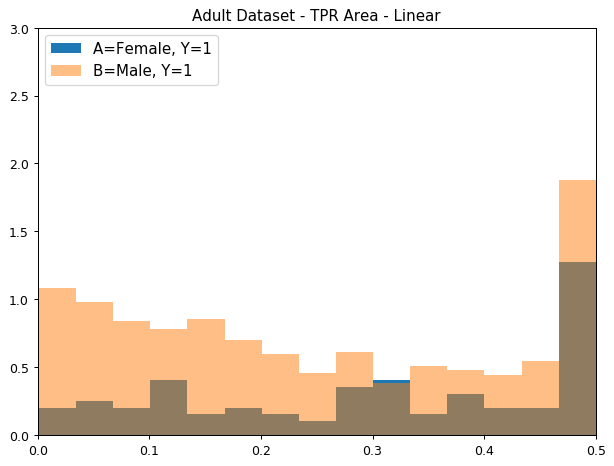

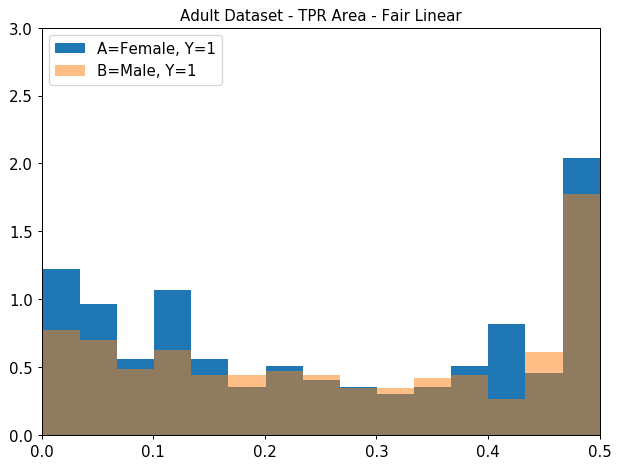

In [18]:
import matplotlib.pyplot as plt

sensitive_feature = sensitive_feature_gender

SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 16
bins = 30

X = training_data_matrix[:, :-1]
y = training_data_matrix[:, -1]
Xte = test_data_matrix[:, :-1]
yte = test_data_matrix[:, -1]
ypos = np.max(y)
yneg = np.min(y)
idx_group_A1 = [idx for idx, v in enumerate(Xte) 
                if v[sensitive_feature] == groupA_value and yte[idx] == ypos]
idx_group_B1 = [idx for idx, v in enumerate(Xte) 
                if v[sensitive_feature] != groupA_value and yte[idx] == ypos]


titles = ['Adult Dataset - TPR Area - Linear',
         'Adult Dataset - TPR Area - Fair Linear']
for i,distance_from_hyperplane in enumerate([distance_from_hyperplane_test,
                                           distance_from_hyperplane_test_fair]):
    distance_from_hyperplane = distance_from_hyperplane - 0.5
    xmin = np.min([np.min(distance_from_hyperplane[idx_group_A1]),
                   np.min(distance_from_hyperplane[idx_group_B1])])
    xmax = np.max([np.max(distance_from_hyperplane[idx_group_A1]),
                   np.max(distance_from_hyperplane[idx_group_B1])])
    fig, ax = plt.subplots(figsize=(8, 6), dpi=90)
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
    #plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title
    pdf, bins, patches = ax.hist(distance_from_hyperplane[idx_group_A1], bins=bins,
                                 density=True, stacked=True, label='A=Female, Y=1', alpha=1.0)
    ax.hist(distance_from_hyperplane[idx_group_B1], bins=bins, density=True,
            stacked=True, label='B=Male, Y=1', alpha=0.5)
    ax.legend(loc='upper left')
    #ax.set_xlim(left=xmin, right=xmax)
    ax.set_xlim(left=0.0, right=xmax)
    ax.set_ylim(0, 3)
    plt.title(titles[i])

plt.show()

### (Optional) Delete the Endpoint

If you're ready to be done with this notebook, please run the delete_endpoint line in the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [19]:
import sagemaker

sagemaker.Session().delete_endpoint(linear_predictor.endpoint)

INFO:sagemaker:Deleting endpoint with name: linear-learner-2018-06-20-20-53-54-262
